# RNN + MNIST

## 0-1. 라이브러리 import

In [3]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable

## 0-2. 하이퍼파라미터 셋팅

In [4]:
sequence_length = 28   # text 문장의 길이
input_size = 28    # word embedding vector의 size
hidden_size = 128   # hidden state vector의 size
num_layers = 2   # 레이어 개수

num_classes = 10
batch_size = 100
num_epochs = 2
learning_rate = 0.01

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 1. MNIST train, test dataset 가져오기
- multi_layered RNN
- many-to-one

In [5]:
# MNIST dataset
mnist_train = dset.MNIST("", train = True, transform = transforms.ToTensor(),
                         target_transform = None, download = True)
mnist_test = dset.MNIST("", train = False, transform = transforms.ToTensor(),
                        target_transform = None, download = True)


Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw




Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## 2. 대략적인 데이터 형태

mnist_train 길이:  60000
mnist_test 길이:  10000
image data 형태:  torch.Size([1, 28, 28])
label:  5


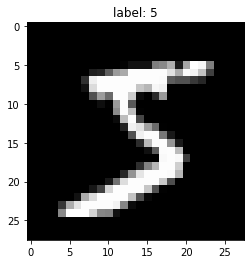

In [6]:
print("mnist_train 길이: ", len(mnist_train))
print("mnist_test 길이: ", len(mnist_test))

# 데이터 하나 형태
image, label = mnist_train.__getitem__(0)  # 0번째 데이터
print("image data 형태: ", image.size())
print("label: ", label)

# 그리기
img = image.numpy()  # image 타입을 numpy로 변환 (1, 28, 28)
plt.title("label: %d" %label)
plt.imshow(img[0], cmap = 'gray')
plt.show()


## 3. 데이터 로드함수
학습시킬 때 batch_size 단위로 끊어서 로드하기 위함

In [7]:
# data loader 
train_loader = torch.utils.data.DataLoader(dataset = mnist_train,
                                           batch_size = batch_size, 
                                           shuffle = True,
                                           drop_last = True)  # batch_size만큼 나눌 때 나머지는 버려라

test_loader = torch.utils.data.DataLoader(dataset = mnist_test,
                                          batch_size = batch_size, 
                                          shuffle = True,
                                          drop_last = True)  # test에서는 shuffle 하지 않음                                                                            

### 데이터 로드함수 이해하기

[0]
한 번에 로드되는 데이터 크기:  100


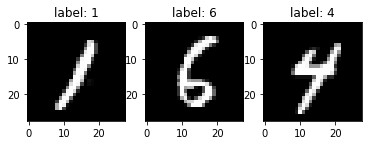

[1]
한 번에 로드되는 데이터 크기:  100


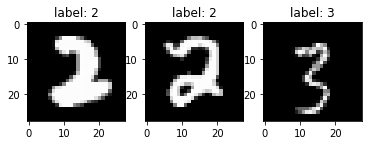

[2]
한 번에 로드되는 데이터 크기:  100


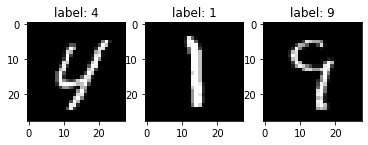

[3]
한 번에 로드되는 데이터 크기:  100


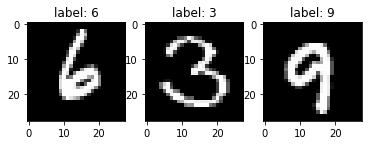

[4]
한 번에 로드되는 데이터 크기:  100


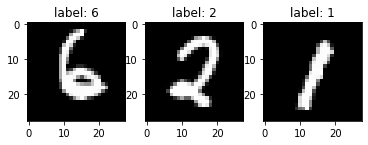

[5]
한 번에 로드되는 데이터 크기:  100


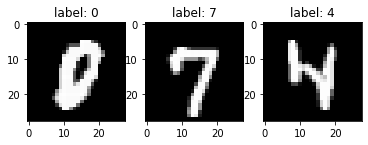

In [9]:
n = 3  # 샘플로 그려볼 데이터 개수
for i, [imgs, labels] in enumerate(test_loader):  # batch_size만큼
    if i>5: 
        break

    print("[%d]" %i)
    print("한 번에 로드되는 데이터 크기: ", len(imgs))

    # 그리기
    for j in range(n):
        img = imgs[j].numpy()  # image 타입을 numpy로 변환 (1, 28, 28)
        img = img.reshape((img.shape[1], img.shape[2]))  # (1,28,28) -> (28,28)
        
        plt.subplot(1, n, j+1)  # (1,3)형태 플랏의 j번째 자리에 그리겠다
        plt.imshow(img, cmap = 'gray')
        plt.title("label: %d" %labels[j])
    plt.show()

## 4. 모델 선언

In [11]:
# Recurrent neural network (many-to-one)
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)  # batch_first: batch_size를 가장 처음으로 
        self.fc = nn.Linear(hidden_size, num_classes) #@@@@@@@@@@@@@@@@@

    def forward(self, x):
        # -------
        # input tensor: (batch_size, seq_length, input_size)
        # x: (100, 28, 28)
        # print('x: ', x.shape)

        # -------
        # hidden state tensor: (# of layers, batch_size, hidden_size)
        # h: (2, 100, 128)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)  # @@@@@@@@@@@@@@@
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)  # @@@@@@@@@@@@@@@

        # -------
        # Forward propagate LSTM
        # output tensor: (batch_size, seq_length, hidden_size)
        # out: (100, 28, 128)
        # print('out: ', out.shape)
        
        out, _ = self.lstm(x, (h0, c0))

        # -------
        # 28번째 output layer: (bs, hidden_size)
        # out[:, -1, :]: (100, 128)
        # print('out[-1]: ', out[:, -1, :].shape)

        # -------
        out = self.fc(out[:, -1, :])

        # y^ : (batch_size, num_classes)
        # y_pred: (100, 10)
        # print('out: ', out.shape)
        return out

In [12]:
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

In [15]:
def ComputeAccr(dloader, imodel):
    correct = 0
    total = 0

    for j, [imgs, labels] in enumerate(dloader):  # batch_size 만큼
        # x: (batch_size, 1, seq_length, input_size) -> (batch_size, seq_length, input_size)
        img = imgs
        img = img.reshape(-1, sequence_length, input_size).to(device)

        # y: (batch_size, num_classes)
        label = labels.to(device)  # Variable(labels)
        # label = Variable(labels).cuda()
        # .cuda(): GPU에 로드되기 위함. 만약 CPU로 설정되어 있다면 에러남

        # Forward prop.
        output = imodel(img)  # (batch_size, num_classes)
        _, output_index = torch.max(output, 1)  # (batch_size, 1)

        total += label.size(0)
        correct += (output_index == label).sum().float()
    # print("Accuracy of Test Data: {}".format(100*correct/total))
    return (100*correct/total).numpy()  # tensor -> numpy

In [16]:
print("Accuracy of Test Data: %.2f" %ComputeAccr(test_loader, model))  # 

Accuracy of Test Data: 8.92


## 5. loss, optimizer

In [17]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

## 6. 학습

In [19]:
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, [imgs, labels] in enumerate(train_loader):
        # x: (batch_size, 1, seq_length, input_size) -> (batch_size, seq_length, input_size)
        img = imgs
        img = img.reshape(-1, sequence_length, input_size).to(device)

        # y: (batch_size, num_classes)
        label = labels.to(device)  # y # Variable(labels)

        # Forward prop
        outputs = model(img)
        loss = loss_func(outputs, labels)

        # Backward prop & optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1)%100 ==0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accr: {:.2f}'
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item(), ComputeAccr(test_loader, model)))

Epoch [1/2], Step [100/600], Loss: 0.3105, Accr: 81.48
Epoch [1/2], Step [200/600], Loss: 0.1982, Accr: 88.82
Epoch [1/2], Step [300/600], Loss: 0.1193, Accr: 94.37
Epoch [1/2], Step [400/600], Loss: 0.1058, Accr: 96.36
Epoch [1/2], Step [500/600], Loss: 0.1182, Accr: 96.70
Epoch [1/2], Step [600/600], Loss: 0.0719, Accr: 96.30
Epoch [2/2], Step [100/600], Loss: 0.1861, Accr: 96.48
Epoch [2/2], Step [200/600], Loss: 0.0902, Accr: 97.08
Epoch [2/2], Step [300/600], Loss: 0.0607, Accr: 97.50
Epoch [2/2], Step [400/600], Loss: 0.0926, Accr: 97.20
Epoch [2/2], Step [500/600], Loss: 0.0958, Accr: 96.75
Epoch [2/2], Step [600/600], Loss: 0.0770, Accr: 97.72


## 7. 테스트

In [20]:
print("Accuracy of Test Data: %.2f" %ComputeAccr(test_loader, model))

Accuracy of Test Data: 97.72


## 8. 학습된 파라미터 저장

In [21]:
netname = '/content/drive/MyDrive/Module11/rnn_weight.pkl'
torch.save(model, netname, )

## 9. 학습된 파라미터 로드
실무에서 학습된(pretrained) 파라미터 로드하고 싶다면 5,6,8 과정 생략한 채 실행


In [22]:
netname = '/content/drive/MyDrive/Module11/rnn_weight.pkl'
model = torch.load(netname)

In [23]:
print("Accuracy of Test Data: %.2f" %ComputeAccr(test_loader, model))

Accuracy of Test Data: 97.72
